In [191]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import os
import json
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from nltk.tokenize import sent_tokenize, word_tokenize
sys.path.append("/Users/rohanramesh/Documents/GitHub/Insight_writers/lib/")
from text_processing import ProcessArticle as pa
import suggestions as s
import difflib
from scipy.stats import wilcoxon, sem

In [2]:
# data load
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt3_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)
    
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)
    
# load writer features
writer_features = pd.read_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_features.pickle')

# load podcasts
top_podcasts = pd.read_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/top50podcasts.pickle')


In [3]:
dbname = 'writer_feature_db'
# dbname = 'writer_db'
username = 'rohanramesh' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
con = None
con = psycopg2.connect(database = dbname, user = username)

postgres://rohanramesh@localhost/writer_feature_db
True


In [4]:
# query to load entire db into pandas
sql_query = """
SELECT * FROM writer_feature;
"""
writer_feature_df = pd.read_sql_query(sql_query,con)

In [216]:
writer_feature_df.head()

,level_0,index,n_words,author_id_n,author_list,mongo_id,n_nouns,n_adj,n_verb,n_adv,...,n_wordspersent_variability,neg_sent,neu_sent,pos_sent,neg_sent_var,neu_sent_var,pos_sent_var,wordlength,wordlength_var,wordlength_skew
0,0,0,2966,693716,zachlowe_nba,5b9c705c11919a2b1a15c30d,1245,67,413,102,...,17.212670,0.078108,0.839638,0.082249,0.134054,0.185814,0.143422,4.801696,2.667325,1.402407
1,1,1,2966,693716,zachlowe_nba,5b9c705d11919a2b1a15c30e,1245,67,413,102,...,17.212670,0.078108,0.839638,0.082249,0.134054,0.185814,0.143422,4.801696,2.667325,1.402407
2,2,2,2697,693716,zachlowe_nba,5b9c705f11919a2b1a15c30f,1000,60,363,112,...,16.185666,0.037828,0.869960,0.092225,0.083719,0.139230,0.123817,4.607130,2.427109,1.110728
3,3,3,2813,693716,zachlowe_nba,5b9c706011919a2b1a15c310,1060,58,411,86,...,11.751734,0.059246,0.854087,0.086639,0.106565,0.143424,0.122222,4.571527,2.405555,1.074744
4,4,4,2813,693716,zachlowe_nba,5b9c706111919a2b1a15c311,1060,58,411,86,...,11.751734,0.059246,0.854087,0.086639,0.106565,0.143424,0.122222,4.571527,2.405555,1.074744


In [6]:
sql_query = """
SELECT AVG("n_words") AS "avg_n_words",
         AVG("neg_sent") AS "avg_neg_sent",
         AVG("neu_sent") AS "avg_neu_sent",
         AVG("pos_sent") AS "avg_pos_sent",
         AVG("neg_sent_var") AS "avg_neg_sent_var",
         AVG("neu_sent_var") AS "avg_neu_sent_var",
         AVG("pos_sent_var") AS "avg_pos_sent_var",
        AVG("n_sentences") AS "avg_n_sentences",
        AVG("n_wordspersentence") AS "avg_n_wordspersentence",
        AVG("n_wordspersent_variability") AS "avg_n_wordspersent_variability",
        AVG("wordlength") AS "avg_wordlength",
        AVG("wordlength_var") AS "avg_wordlength_var",
        AVG("wordlength_skew") AS "avg_wordlength_skew",
        "author_list"
FROM writer_feature
WHERE "n_words" > 100
GROUP BY "author_list"
HAVING COUNT(*) > 25 
ORDER BY AVG("n_words") DESC
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)
writer_feature_subsection.replace([np.inf, -np.inf], np.nan)
writer_feature_subsection = writer_feature_subsection.dropna(axis=0, how='any')

In [9]:
author_webnames = writer_feature_subsection['author_list']
author_list = []
for i in author_webnames:
    idx = writer_df['website_name'] == i
#     print(i)
#     print(writer_df['Idea Text'][np.where(idx)[0]].tolist()[0])
#     break
    author_list.append(writer_df['Idea Text'][np.where(idx)[0]].tolist()[0])
    
# author_list[41] = 'Jason Concepcion'

In [100]:
# type something in search key
# new_id = url_format.format('zach', 'lowe')
# new_id = 'https://www.listennotes.com/search/?q=zach%20lowe'
page = requests.get(url_format)
curr_soup = BeautifulSoup(page.text)

In [102]:
r = curr_soup.find("div", {"class": "info ellipsis"})

In [254]:
# top_podcasts = {}
# for curr_author in author_list:
#     top_podcasts[curr_author] = []
#     r = word_tokenize(curr_author)
#     page_idx = 0
#     while page_idx < 50:
# #         url = ("https://listennotes.p.mashape.com/api"
# #             "/v1/search?offset={}&q={}+{}&sort_by_date=0&type=episode".format(page_idx,r[0], r[1]))
# #         response = requests.get(url,
# #           headers={
# #             "X-Mashape-Key": "JwHAxYJ4eKmshUhN2Z7c6wf653Tsp1Q5Ug0jsnYBp1DONOnaVX",
# #             "Accept": "application/json"
# #           }
# #         )
#         a = response.content
#         b = json.loads(a)
#         top_podcasts[curr_author].append(b)
#         page_idx += 10
#         time.sleep(random.uniform(0.5,2))
#         print(url)


https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Steve+Kyler&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Steve+Kyler&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Steve+Kyler&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Steve+Kyler&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Steve+Kyler&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Chris+Ballard&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Chris+Ballard&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Chris+Ballard&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Chris+Ballard&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Chris+Ballard&sort_by_date=0&type=

https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Mark+Deeks&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Mark+Deeks&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Mark+Deeks&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Mark+Deeks&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Rob+Mahoney&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Rob+Mahoney&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Rob+Mahoney&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Rob+Mahoney&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Rob+Mahoney&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Dan+Devine&sort_by_date=0&type=episode
https:/

https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Howard+Beck&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Howard+Beck&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Scott+Howard-Cooper&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Scott+Howard-Cooper&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Scott+Howard-Cooper&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Scott+Howard-Cooper&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Scott+Howard-Cooper&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Chris+Mannix&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Chris+Mannix&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=

https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Tom+Ziller&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Rory+Masterson&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Rory+Masterson&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Rory+Masterson&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Rory+Masterson&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Rory+Masterson&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Brian+Windhorst&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Brian+Windhorst&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Brian+Windhorst&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Brian+Windhorst&

https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Andrew+Bernucca&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Andrew+Bernucca&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Andrew+Bernucca&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Andrew+Bernucca&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Shams+Charania&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Shams+Charania&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Shams+Charania&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Shams+Charania&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Shams+Charania&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Sam+Amico&s

https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Brady+Klopfer&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Brady+Klopfer&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Brady+Klopfer&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Justin+Jett&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Justin+Jett&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=20&q=Justin+Jett&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=30&q=Justin+Jett&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=40&q=Justin+Jett&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=0&q=Derek+Bodner&sort_by_date=0&type=episode
https://listennotes.p.mashape.com/api/v1/search?offset=10&q=Derek+Bodner&sort_by_date=0&type=ep

In [111]:
# These code snippets use an open-source library. http://unirest.io/python
response = requests.get("https://listennotes.p.mashape.com/api/v1/search?offset=0&q=zach+lowe&sort_by_date=0&type=episode",
  headers={
    "X-Mashape-Key": "KEYINEMAIL",
    "Accept": "application/json"
  }
)

In [179]:
response.content

b'{"took": 0.684, "results": [{"transcripts_highlighted": [" household but this delay to my vacation\\n\\n00:00:51  is <span class=\\"ln-search-highlight\\">allowed</span> me to talk about a couple teams I was kind of interested in talking about anyway and that made an interesting trade and to talk about the", " waved at a <span class=\\"ln-search-highlight\\">lower</span> number that they could find out today there was a lot of different things what they\\n\\n00:07:02  settled on it they might get a shooter is a twenty four year old starting point guard the"], "image": "https://d3sv2eduhewoas.cloudfront.net/channel/image/137f13e8339e445d9a8ac31a838b5e7f.jpg", "itunes_id": 986595124, "id": "418f6ce5778a4924b5174f6705a39537", "rss": "https://www.listennotes.com/c/r/b44cc0faed314af0886f422154d0ccd6", "title_original": "Royce Young; Chris Herring", "podcast_listennotes_url": "https://www.listennotes.com/c/b44cc0faed314af0886f422154d0ccd6/", "publisher_highlighted": "ESPN, NBA, <span class

In [229]:
# import ast
# d = ast.literal_eval(a)
# print(ast.literal_eval(a))
a = response.content
b = json.loads(a)

In [230]:
b.keys()

dict_keys(['took', 'results', 'count', 'next_offset', 'total'])

In [255]:
# for saving podcast info
# with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/top50podcasts.pickle', 'wb') as handle:
#     pickle.dump(top_podcasts, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [256]:
response.headers

{'CF-RAY': '45f201da4c3e9574-IAD', 'Content-Encoding': 'gzip', 'Content-Type': 'application/json', 'Date': 'Mon, 24 Sep 2018 03:01:34 GMT', 'Expect-CT': 'max-age=604800, report-uri="https://report-uri.cloudflare.com/cdn-cgi/beacon/expect-ct"', 'Server': 'Mashape/5.0.6', 'Set-Cookie': '__cfduid=db7e61252bad0f34e41b68fa5e71ef1531537758094; expires=Tue, 24-Sep-19 03:01:34 GMT; path=/; domain=.listennotes.com; HttpOnly', 'Vary': 'Cookie', 'X-Cache-Status': 'MISS', 'X-Frame-Options': 'SAMEORIGIN', 'X-RateLimit-directory-apis-Limit': '1000', 'X-RateLimit-directory-apis-Remaining': '1000', 'X-RateLimit-full-text-search-quota-Limit': '1000', 'X-RateLimit-full-text-search-quota-Remaining': '536', 'X-RateLimit-typeahead-quota-Limit': '10000', 'X-RateLimit-typeahead-quota-Remaining': '10000', 'Content-Length': '3382', 'Connection': 'keep-alive'}

In [12]:
# for each podcast lets identify fields to search
author_mentions = np.zeros([len(author_list), len(author_list)])
for i in range(0,len(author_list)):
    curr_author = author_list[i]
    # curr_page = 0
    for curr_page in range(0,4):
    # curr_pod = 0
        for curr_pod in range(0,np.min([9,len(top_podcasts[curr_author][curr_page]['results'])])):
            curr_info = top_podcasts[curr_author][curr_page]['results'][curr_pod]
            podcast_keys = curr_info.keys()
            matches = []
            for curr_key in podcast_keys:
                for j in range(0,len(author_list)):
                    curr_authorcomp = author_list[j]
                    if curr_authorcomp == 'Jason Concepcion/netw3rk':
                        curr_authorcomp = 'Jason Concepcion'
                    search_terms = curr_authorcomp
                    #     matches = []
                    if isinstance(curr_info[curr_key], str):
                #         print(curr_info[curr_key])
                        last_name = word_tokenize(search_terms)[1]
                #         print(last_name)
                    #     for word in search_terms.split(" "):
                    #         print(word)
                        if last_name in curr_info[curr_key]:
                            author_mentions[i,j] = 1
                        

In [36]:
writer_df.head()

,Wikisurvey ID,Idea ID,Idea Text,Wins,Losses,Times involved in Cant Decide,Score,User Submitted,Session ID,Created at,Last Activity,Active,Appearances on Left,Appearances on Right,Info,website_name
0,11361,693716,Zach Lowe,2951,288,100,91.0830,False,5012316,2017-09-13 15:28:25 UTC,2017-10-03 01:44:17 UTC,True,1821,1908,NaN,zachlowe_nba
1,11361,693715,Adrian Wojnarowski,2457,732,118,77.0291,False,5012316,2017-09-13 15:28:25 UTC,2017-10-03 01:40:16 UTC,True,1855,1835,NaN,adrian-wojnarowski
2,11361,693742,Lee Jenkins,2421,746,260,76.4279,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:43:04 UTC,True,1917,1841,NaN,lee-jenkins
3,11361,693755,Howard Beck,2425,748,186,76.4094,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:44:13 UTC,True,1839,1864,NaN,howardbeck
4,11361,693719,Marc Stein,2426,759,120,76.1531,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:44:11 UTC,True,1788,1898,NaN,marc-stein


In [47]:
# curr_info
# top_podcasts[curr_author][curr_page]
# np.min([9,len(top_podcasts[curr_author][curr_page]['results'])])
def match_author_names(writer_df, author):
    wa = writer_df['website_name'].tolist()
    al = writer_df['Idea Text'].tolist()
    if author in wa:
        return al[wa.index(author)]
    elif author in al:
        return wa[al.index(author)]
    else:
        print('improper author name')
            

In [41]:
wa = writer_df['website_name'].tolist()
al = writer_df['Idea Text'].tolist()
if 'zachlowe_nba' in al:
    print('woo')


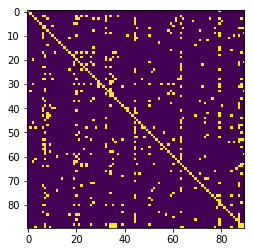

In [13]:
# a = np.sum(author_mentions, axis=0)
# a
plt.imshow(author_mentions)

In [67]:
r = 'Zach Lowe'
idx = np.where(author_mentions[author_list.index(r)])
b = [author_list[i] for i in idx[0] if author_list[i] != r]
b

['Bill Simmons',
 'Howard Beck',
 'Chris Herring',
 'Brian Windhorst',
 'Chris Haynes',
 'Adrian Wojnarowski',
 'Austin Green',
 'Marcus Thompson',
 'Tim Kawakami']

In [69]:
author_sugg = s.give_author_suggestion_from_author(writer_features, 'zachlowe_nba')
print(author_sugg['authors'].tolist())

['zachlowe_nba', 'lee-jenkins', 'chris-ballard', 'howardbeck', 'jonathan-tjarks', 'james-holas', 'billsimmons', 'seerat-sohi', 'dennis-chambers', 'michael-pina']


In [205]:
# iterate each author and see how many times match in podcasts in either direction
# for i in range(0,len(author_list)):
website_author_names = writer_df['website_name'].tolist()
matched_fraction = []
nonmatch_fraction = []
for ii in range(0,len(author_list)):
# ii = 7
    if np.sum(author_mentions[ii,:]) <= 1:
        print(author_list[ii])
        continue
    curr_author = author_list[ii]
    website_name = match_author_names(writer_df, curr_author)
    author_sugg = s.give_author_suggestion_from_author(writer_features, website_name)
    author_sugg_list = author_sugg['authors'].tolist()
    matched_authors = author_sugg_list[0:6]
#     print(matched_authors)
    nonmatched_authors = [i for i in website_author_names if i not in matched_authors]
    # to remove same author
    matched_authors = matched_authors[1:]
    # get n for matched authors
    n_match = []
    for i in matched_authors:
        idx1 = author_list.index(curr_author)
        idx2 = author_list.index(match_author_names(writer_df, i))
        val = np.max([author_mentions[idx1,idx2], author_mentions[idx2,idx1]])
        n_match.append(val)
    matched_fraction.append(np.sum(n_match)/len(n_match))
    n_nonmatch = []
    for i in nonmatched_authors:
        if match_author_names(writer_df, i) in author_list:
            idx1 = author_list.index(curr_author)  
            idx2 = author_list.index(match_author_names(writer_df, i))
            val = np.max([author_mentions[idx1,idx2], author_mentions[idx2,idx1]])
            n_nonmatch.append(val)
    nonmatch_fraction.append(np.sum(n_nonmatch)/len(n_nonmatch))


Chris Ballard
Justin Jett


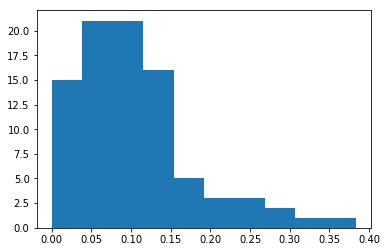

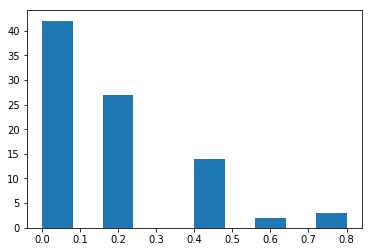

0.1659090909090909
0.10227583633876383
1.6221729085603112


0.004691316493356539

In [206]:
plt.hist(nonmatch_fraction)
plt.show()
plt.hist(matched_fraction)
plt.show()
print(np.mean(matched_fraction))
print(np.mean(nonmatch_fraction))
# (np.mean(matched_fraction)-np.mean(nonmatch_fraction))/np.mean(matched_fraction)
# print((np.mean(nonmatch_fraction)*100)/(np.mean(matched_fraction)*100-np.mean(nonmatch_fraction)*100))
print(np.mean(matched_fraction)/np.mean(nonmatch_fraction))
a,pval = wilcoxon(matched_fraction, nonmatch_fraction)
pval

0.004691316493356539

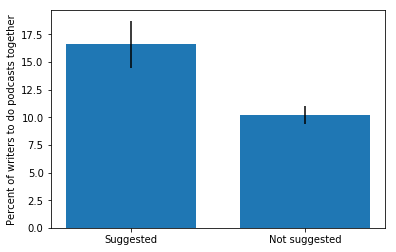

In [215]:
# plt.boxplot([matched_fraction, nonmatch_fraction])
plt.bar(range(0,2),[np.mean(matched_fraction)*100, np.mean(nonmatch_fraction)*100], 0.75, 
        yerr=[sem(matched_fraction)*100, sem(nonmatch_fraction)*100], tick_label= ['Suggested', 'Not suggested'])
plt.ylabel('Percent of writers to do podcasts together')
pval

In [343]:
curr_page = 2
curr_author = 'Zach Lowe'
curr_pod = 8
# for curr_pod in range(0,np.min([9,len(top_podcasts[curr_author][curr_page]['results'])])):
curr_info = top_podcasts[curr_author][curr_page]['results'][curr_pod]
podcast_keys = curr_info.keys()
matches = []
for curr_key in podcast_keys:
    for j in range(0,len(author_list)):
        curr_authorcomp = author_list[j]
        search_terms = curr_authorcomp
        #     matches = []
        if isinstance(curr_info[curr_key], str):
#             print(curr_info[curr_key])
            last_name = word_tokenize(search_terms)[1]
    #         print(last_name)
        #     for word in search_terms.split(" "):
        #         print(word)
            if last_name in curr_info[curr_key]:
    #                 author_mentions[i,j] = 1
                print(curr_authorcomp)
                print('woo')
                

Zach Lowe
woo
Brian Windhorst
woo
Zach Lowe
woo
Brian Windhorst
woo
Zach Lowe
woo
Brian Windhorst
woo
Zach Lowe
woo
Brian Windhorst
woo


In [336]:
type(curr_info['description_original'])

str

In [338]:
isinstance(curr_info['description_original'], str)

True